In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
from autodm.llm import get_llm
from autodm.roll import Dice, DiceType
from autodm.character import Character
from autodm.locaitons import Location, LocationGraph, setup_new_locations
from autodm.adventurelog import AdventureLog
from autodm.storyline import StoryLineWithStoryItems

from typing import List
from rich import print

In [3]:
locations = setup_new_locations()

In [4]:
region = locations[locations.list_locations('region').pop()]
city = locations[locations.list_locations('city').pop()]

In [5]:
# building = city.generate_child(type='building', storyline="The adventurers enter the wizard's guild")
# room1 = building.generate_child(storyline="The adventurers find and enter the wizard's library.")
# room2 = building.generate_child(storyline="The adventurers find and enter thewizard's alchemy lab")
# room3 = building.generate_child(storyline="The adventurers find and enter thewizard's training range")
# locations.add_location(building)
# locations.add_location(room1)
# locations.add_location(room2)
# locations.add_location(room3)
# locations.set_current_location(room1.name)

In [6]:
character = Character.generate(level=0)
print(character)

Character(
    chr_class='wizard',
    chr_race='human',
    name='Aldric',
    attributes=Attributes(strength=16, dexterity=10, constitution=12, intelligence=3, wisdom=13, charisma=2),
    level=0,
    max_hp=22,
    hp=22,
    spells=[],
    equipment=[]
)

In [7]:
story = StoryLineWithStoryItems.generate(character, city, region, locations)

In [8]:
print(story)

StoryLineWithStoryItems(
    name='The Lost Relic of Aranthia',
    details='In the Kingdom of Aranthia, rumors have spread about an ancient relic hidden in the ruins of the lost 
city of Eldaran. The relic is said to possess immense power and has been sought after by many for centuries. The 
party has been tasked by the royal family of Aranthia to find and secure the relic before it falls into the wrong 
hands.',
    completed=False,
    items=StoryItems(
        items=[
            StoryItem(
                name='The Lost Relic of Aranthia',
                details='In the Kingdom of Aranthia, rumors have spread about an ancient relic hidden in the ruins 
of the lost city of Eldaran. The relic is said to possess immense power and has been sought after by many for 
centuries. The party has been tasked by the royal family of Aranthia to find and secure the relic before it falls 
into the wrong hands.',
                completed=False
            ),
            StoryItem(
                name='Event 1: The Mysterious Map',
                details='The party discovers a cryptic map that leads them to the entrance of the lost city of 
Eldaran. They must decipher the map and navigate through treacherous terrain to reach their destination.',
                completed=False
            ),
            StoryItem(
                name='Event 2: The Crypt of the Fallen Kings',
                details='Upon entering the lost city, the party finds themselves in the Crypt of the Fallen Kings. 
They must solve puzzles and battle undead guardians to progress through the crypt and find a clue that leads them 
closer to the relic.',
                completed=False
            ),
            StoryItem(
                name='Event 3: The Temple of Aranthia',
                details='The party discovers an ancient temple dedicated to the goddess Aranthia. They must 
complete a series of trials within the temple to unlock its secrets and find another clue that leads them to the 
relic.',
                completed=False
            ),
            StoryItem(
                name='Event 4: The Cavern of Shadows',
                details='The party encounters a dark cavern filled with dangerous creatures and traps. They must 
navigate through the darkness and defeat the boss guarding the final clue to the location of the relic.',
                completed=False
            ),
            StoryItem(
                name='Conclusion: The Lost Relic',
                details='After solving all the puzzles and overcoming numerous challenges, the party finally 
reaches the chamber where the Lost Relic of Aranthia is hidden. They must battle a powerful guardian to claim the 
relic and return it safely to the Kingdom of Aranthia.',
                completed=False
            )
        ]
    )
)

## Location management functions

Things the agent needs to be able to do:

- [ ] List locations
- [ ] Add a new location
- [ ] Set a new location
- [ ] Get locations you can travel to from the current location

In [41]:
from llama_index.core.tools import FunctionTool
from llama_index.core.agent import ReActAgent, StructuredPlannerAgent

In [53]:
def get_current_location() -> str:
    """
    Returns the name of the current location.
    
    Returns:
        str: The name of the current location.
    """
    return locations.current_location.name

def locaiton_info(location_name) -> str:
    """
    Returns the information about a location.
    
    Args:
        location_name (str): The name of the location.
        
    Returns:
        str: The information about the location.
    """
    if location_name not in locations.list_locations():
        return f"Location {location_name} not found, check the spelling or create a new location."
    loc = locations[location_name].model_dump()
    s = "\n".join([f"{k}: {v}" for k, v in loc.items()])
    return s

def add_new_location(storyline:str, parent_name:str=None, location_name:str=None) -> str:
    """
    Adds a new location to the location graph.
    
    Args:
        storyline (str): The storyline related to the creation of the new location. 
        parent_name (str): The name of the parent location. If none is given, the current location is used.
        location_name (str): The name of the location. If none is given, one will be made up.
        
    Returns:
        str: The name of the new location.
    """
    if not parent_name:
        parent = locations.current_location
    else:
        parent = locations[parent_name]
    kwargs = {}
    if location_name is not None:
        kwargs["name"] = location_name
    location = parent.generate_child(storyline=storyline, **kwargs)
    locations.add_location(location)
    return location.name

def travel_plan(destionation_name:str) -> List[str]:
    """
    Returns a list of location names that the character will travel through to reach the destination.

    Args:
        destionation_name (str): The name of the destination location.

    Returns:
        str: The name of the destination location.
    """
    return locations.travel_plan(destionation_name)

def travel_to(destination_name:str) -> str:
    """
    Travels to a location.
    
    Args:
        destination_name (str): The name of the destination location.
        
    Returns:
        str: The name of the destination location.
    """
    locations.set_current_location(destination_name)
    return locations.current_location.name

tools = [
    
]

In [54]:
location_tools = [
    FunctionTool.from_defaults(get_current_location),
    FunctionTool.from_defaults(locaiton_info),
    FunctionTool.from_defaults(add_new_location),
    FunctionTool.from_defaults(travel_plan),
    FunctionTool.from_defaults(travel_to),
]

In [55]:
location_agent = ReActAgent.from_tools(location_tools, llm=get_llm(), verbose=2)
# location_agent = StructuredPlannerAgent.from_tools(location_tools, llm=get_llm(), verbose=2)

In [56]:
details = story.items.items[1].details

In [57]:
location_agent.chat(f"Create all the locations required to address the following quest: {details}")

Thought: The current language of the user is: English. I need to use a tool to help me create all the locations required for this quest.
Action: add_new_location
Action Input: {'storyline': 'The party reaches the entrance of the lost city of Eldaran.', 'parent_name': 'Treacherous Terrain'}
Observation: Error: 'Treacherous Terrain'
Thought: The error suggests that the parent location is not defined. I'll create a new location for "Treacherous Terrain" first.
Action: add_new_location
Action Input: {'storyline': 'The party discovers a cryptic map leading to the lost city of Eldaran.', 'location_name': 'Treacherous Terrain'}
Observation: The Golden Scales Inn
Thought: I received an observation but it doesn't seem relevant to the current task. Let me continue with creating the required locations for the quest.
Action: add_new_location
Action Input: {'storyline': 'The party deciphers the cryptic map and sets off towards the lost city of Eldaran.', 'parent_name': 'Treacherous Terrain', 'locat

ValueError: Reached max iterations.

In [26]:
locations.list_locations()

['The Kingdom of Aranthia', "Aranthia's Landing"]

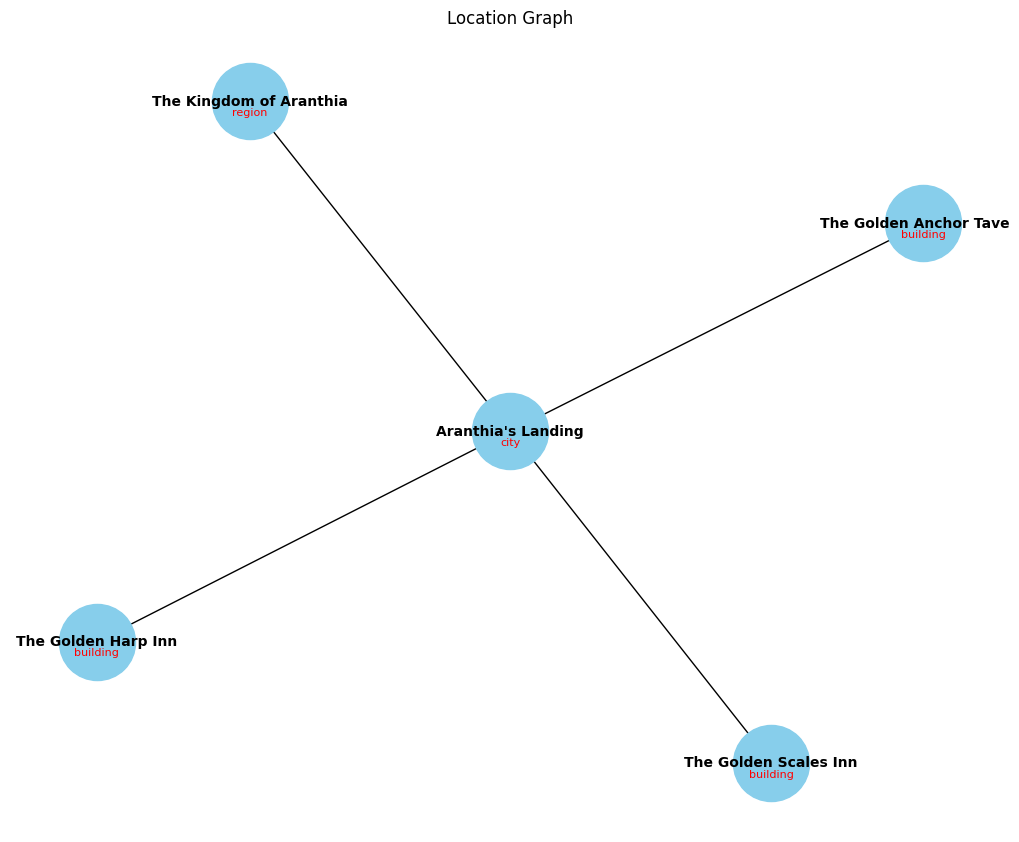

In [58]:
locations.visualize()